# Data preprocessing

In [1]:
import pandas as pd

pd.set_option('display.max_rows', 50)

clinical_data = pd.read_excel("TRAIN/Training_Unlabeled_Clinical_Data.xlsx")
biomarker_data = pd.read_csv("TRAIN/Training_Biomarker_Data.csv")

# Extract Meta Data
meta = clinical_data["File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Arm", "Folder", "Visit", "Eye", "Image_Name"]
clinical_data[meta.columns] = meta

# Fix missing meta columns
idx = clinical_data["Image_Name"].isna()
clinical_data.loc[idx, ["Folder", "Visit", "Eye", "Image_Name"]] = clinical_data.loc[idx, ["Arm", "Folder", "Visit", "Eye"]].values
clinical_data.loc[idx, "Arm"] = None

columns = biomarker_data.columns.tolist()
columns[0] = clinical_data.columns[0]
biomarker_data.columns = columns

biomarker_clinical = pd.merge(biomarker_data, clinical_data, on="File_Path", how="left")

missing_idx = lambda x: x["Eye_ID"].isna()

meta = biomarker_clinical.loc[missing_idx, "File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Folder", "Visit", "Eye", "Image_Name"]
biomarker_clinical.loc[missing_idx, meta.columns] = meta

biomarker_clinical.loc[missing_idx, "Eye_ID"] = 79
biomarker_clinical = biomarker_clinical.drop(['Patient_ID', 'BCVA', 'CST'], axis = 1)
biomarker_clinical["File_Path"] = "TRAIN/OLIVES" + biomarker_clinical["File_Path"]

In [2]:
test_df = pd.read_csv('test_set_labels.csv')
columns = test_df.columns.tolist()
columns[0] = clinical_data.columns[0]
test_df.columns = columns

test_df["File_Path"] = "/" + test_df["File_Path"]
#meta = test_df["File_Path"].str.split("/", expand=True)
#meta = meta.drop(0, axis=1)
#meta.columns = ["Trial", "Arm", "Folder", "Visit", "Eye", "Image_Name"]
#test_df[meta.columns] = meta
test_df["File_Path"] = "TEST" + test_df["File_Path"]

In [3]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

labels = ["B1", "B2", "B3", "B4", "B5", "B6"]

eye_ids = biomarker_clinical.groupby("Eye_ID")[["B1", "B2", "B3", "B4", "B5", "B6"]].mean().round().astype(int)

mskf = MultilabelStratifiedKFold(n_splits=8, shuffle=True, random_state=3000)

train_index, test_index = next(iter(mskf.split(eye_ids.index, eye_ids)))

In [4]:
train_ids, val_ids = eye_ids.index[train_index], eye_ids.index[test_index]
train_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(train_ids), ["File_Path"] + labels]
val_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(val_ids), ["File_Path"] + labels]

In [5]:
import numpy as np
filtered_values = np.where((test_df['B1'] == 0) & (test_df['B2'] == 1))

In [6]:
filtered_test_df = test_df.loc[filtered_values]

In [7]:
train_df = pd.concat([train_df, filtered_test_df])

In [8]:
train_df["B1"].value_counts(), train_df["B2"].value_counts(), train_df["B3"].value_counts(), train_df["B4"].value_counts(), train_df["B5"].value_counts(), train_df["B6"].value_counts()

(1    5525
 0    3568
 Name: B1, dtype: int64,
 0    5616
 1    3477
 Name: B2, dtype: int64,
 1    4628
 0    4465
 Name: B3, dtype: int64,
 0    6396
 1    2697
 Name: B4, dtype: int64,
 0    6434
 1    2659
 Name: B5, dtype: int64,
 0    5497
 1    3596
 Name: B6, dtype: int64)

In [9]:
biomarker_clinical["B1"].value_counts(), biomarker_clinical["B2"].value_counts(), biomarker_clinical["B3"].value_counts(), biomarker_clinical["B4"].value_counts(), biomarker_clinical["B5"].value_counts(), biomarker_clinical["B6"].value_counts()

(1    6341
 0    3067
 Name: B1, dtype: int64,
 0    6424
 1    2984
 Name: B2, dtype: int64,
 1    5222
 0    4186
 Name: B3, dtype: int64,
 0    6572
 1    2836
 Name: B4, dtype: int64,
 0    6405
 1    3003
 Name: B5, dtype: int64,
 0    5320
 1    4088
 Name: B6, dtype: int64)

In [10]:
import torch
pos_weight_one = 3067/6371
pos_weight_two = 6424/2984
pos_weight_three = 4186/5222
pos_weight_four = 6572/2836
pos_weight_five = 6405/3003
pos_weight_six = 5320/4088
pos_weight = torch.tensor([pos_weight_one, pos_weight_two, pos_weight_three, pos_weight_four, pos_weight_five, pos_weight_six])

# Initialization

In [11]:
%matplotlib inline
from PIL import Image
import torch.utils.data as data
import os
import math
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torchsummary import summary
import torch
import torchvision
from sklearn.metrics import accuracy_score
# import skimage
from skimage.io import imread
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import time
import numpy as np
from sklearn.metrics import f1_score
from sklearn import metrics

In [12]:
import os
import random

import numpy as np
import torch

SEED = 3000

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [13]:
from __future__ import print_function

import math
import numpy as np
import torch
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

# Data Loader 

In [14]:
class OLIVES(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor
    
class RECOVERY(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image

In [15]:
normalize = transforms.Normalize(mean=.1706, std=.2112)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.7, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])
val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.ToTensor(),
        normalize,
    ])

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
train_dataset = OLIVES(train_df, transforms = train_transform)
validation_dataset = OLIVES(val_df, transforms = val_transform)

In [18]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True)

validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True)

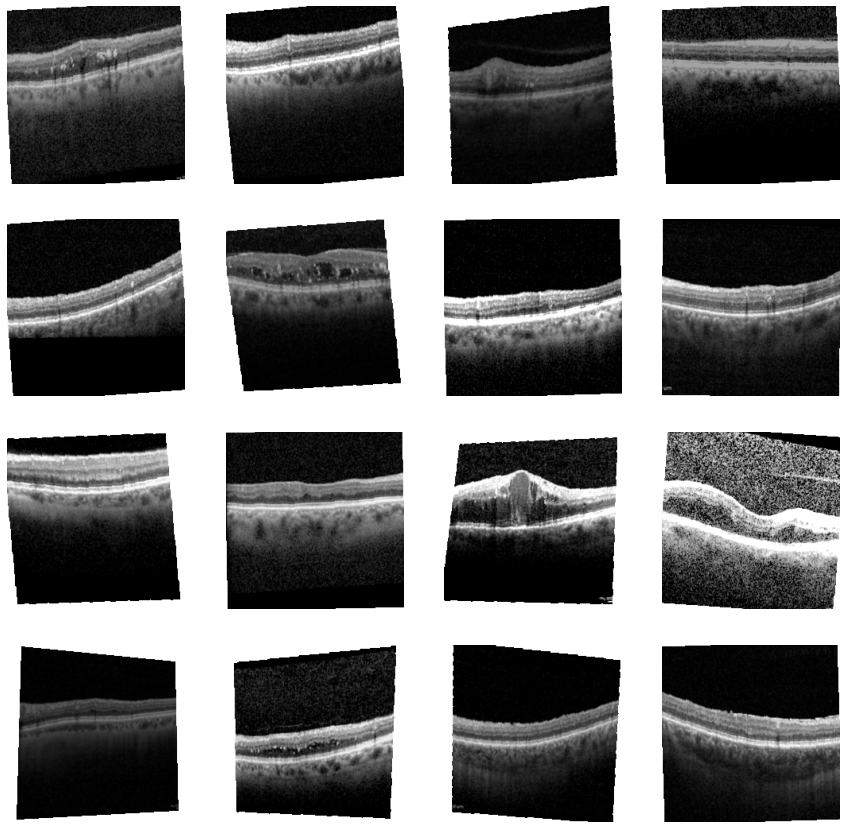

In [19]:
# Plot more images
torch.manual_seed(SEED+1)
fig = plt.figure(figsize=(15, 15))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis(False);

# Device

In [20]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Model 

In [21]:
model = torchvision.models.resnet50(weights=None,zero_init_residual=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Identity(),
    nn.Sequential(
        nn.Linear(2048, 512),
        nn.Linear(512, 6)
    )
)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [22]:
ckpt = torch.load("models/18_vip_cup_student_two_pretrain_random_weight_epoch_36.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)
model.to(device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0544,  0.0051,  0.0451,  ...,  0.0179, -0.0308,  0.0405],
                        [ 0.0235,  0.0161, -0.0863,  ..., -0.1122,  0.0386,  0.0029],
                        [-0.0581, -0.1122, -0.1379,  ..., -0.0007, -0.1304, -0.0878],
                        ...,
                        [ 0.0171, -0.0052,  0.0140,  ...,  0.2270,  0.0912,  0.1055],
                        [ 0.1028,  0.0959,  0.0832,  ...,  0.1204,  0.1818, -0.0260],
                        [-0.1623, -0.0533, -0.1868,  ..., -0.1632, -0.1183,  0.0220]]],
              
              
                      [[[-0.0893, -0.0749,  0.1038,  ..., -0.0832,  0.0987, -0.1326],
                        [ 0.0597, -0.0305, -0.0210,  ...,  0.0773,  0.0292, -0.0192],
                        [ 0.0251, -0.0523, -0.1291,  ..., -0.1296,  0.0801, -0.0126],
                        ...,
                        [-0.1310, -0.0027,  0.0185,  ...,  0.0565, -0.1021, -0.1020],
                    

# Criterion, Optimizer

In [23]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
criterion = criterion.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

# Balanced accuracy score

In [24]:
from sklearn.metrics import balanced_accuracy_score

def compute_balanced_accuracy(truths, outputs):
    
    return [
        round(balanced_accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [25]:
def compute_accuracy_score(truths, outputs):
    
    return [
        round(accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [26]:
def compute_sensitivity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [27]:
def compute_specificity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred, pos_label=0), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [28]:
def custom_metric(x, y):
    x = np.transpose(x)
    y = np.transpose(y)
    
    return [
        round((2*(a*b)/(a+b)).item(), 4)
        for a, b in zip(x, y)
    ]

# Training

In [29]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True)

In [30]:
# training routine
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

epochs = 60
t_loss = []
v_loss = []
accur = []
bal_accur = []
custom = []
s1 = []
s2 = []
for epoch in range(1, epochs + 1):
    # train
    model.train()
    #classifier.train()
    Train_losses = AverageMeter()
    
    for idx, (image, bio_tensor) in enumerate(train_loader):
        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss


        #features = model(images)
        output = model(images)
        
        loss = criterion(output, labels)
        
        # update metric
        Train_losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Val_losses = AverageMeter()
    y_true = []
    y_pred = []
    model.eval()
    #classifier.eval()    
    for idx, (image, bio_tensor) in enumerate(validation_loader):
        # Validation

        with torch.inference_mode():
            images = image.to(device)

            labels = bio_tensor.float()

            labels = labels.to(device)
            bsz = labels.shape[0]

            # compute loss


            #features = model(images)
            output = model(images)
            loss = criterion(output, labels)
            
            
            output = torch.round(torch.sigmoid(output))
            output = output.squeeze().detach().cpu().numpy()
            labels = labels.squeeze().detach().cpu().numpy()
            y_true.append(labels)
            y_pred.append(output)
            Val_losses.update(loss.item(), bsz)
    
    test_true = np.transpose(y_true)
    test_pred = np.transpose(y_pred)
    acc = compute_accuracy_score(test_true, test_pred)
    balanced_acc = compute_balanced_accuracy(test_true, test_pred)
    sen = compute_sensitivity(test_true, test_pred)
    spe = compute_specificity(test_true, test_pred)
    cus_met = custom_metric(sen, spe)
    
    t_loss.append(Train_losses.avg)
    v_loss.append(Val_losses.avg)
    accur.append(np.mean(acc))
    bal_accur.append(np.mean(balanced_acc))
    custom.append(np.mean(cus_met))
    s1.append(np.mean(sen))
    s2.append(np.mean(spe))
    print('-' * 10)
    print(f"{epoch}/{epochs}")
    print(f"Train loss: {Train_losses.avg:.5f} | Validation loss: {Val_losses.avg:.5f}")
    print(f"Accuracy: {acc} | Mean Accuracy: {np.mean(acc):.5f}")       
    print("Balanced acc (val): {} | Mean Balanced acc (val): {:.4f}".format(balanced_acc, np.mean(balanced_acc)))
    print(f"Sensitivity: {sen} | Mean Sensitivity: {np.mean(sen):.5f}")
    print(f"Specificity: {spe} | Mean Specificity: {np.mean(spe):.5f}")
    print(f"Custom Metric: {cus_met} | Mean Custom Metric: {np.mean(cus_met):.5f}")
    print('-' * 10)
    if epoch % 1 == 0:
        MODEL_NAME = f"18_vip_cup_student_two_finetune_random_weight_epoch_{epoch}.pth"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
        state = {'model': model.state_dict(),
                 'optimizer': optimizer.state_dict(),
                 'epoch': epoch,
                }
        # Save the model state dict
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(state,
                   f=MODEL_SAVE_PATH)
        del state      

----------
1/60
Train loss: 0.43410 | Validation loss: 0.47662
Accuracy: [0.7738, 0.807, 0.8146, 0.8444, 0.869, 0.8673] | Mean Accuracy: 0.82935
Balanced acc (val): [0.8005, 0.8092, 0.8135, 0.7888, 0.8308, 0.8566] | Mean Balanced acc (val): 0.8166
Sensitivity: [[0.7316, 0.8152, 0.9242, 0.6616, 0.7326, 0.7351]] | Mean Sensitivity: 0.76672
Specificity: [[0.8694, 0.8032, 0.7027, 0.916, 0.929, 0.9781]] | Mean Specificity: 0.86640
Custom Metric: [0.7946, 0.8092, 0.7984, 0.7683, 0.8192, 0.8394] | Mean Custom Metric: 0.80485
----------
Saving model to: models\18_vip_cup_student_two_finetune_random_weight_epoch_1.pth
----------
2/60
Train loss: 0.38852 | Validation loss: 0.46873
Accuracy: [0.7611, 0.7738, 0.773, 0.8546, 0.875, 0.8861] | Mean Accuracy: 0.82060
Balanced acc (val): [0.81, 0.8065, 0.7728, 0.7987, 0.864, 0.8802] | Mean Balanced acc (val): 0.8220
Sensitivity: [[0.6838, 0.894, 0.7845, 0.6707, 0.8357, 0.8134]] | Mean Sensitivity: 0.78035
Specificity: [[0.9361, 0.7191, 0.7612, 0.9266, 

----------
15/60
Train loss: 0.30219 | Validation loss: 0.54635
Accuracy: [0.7636, 0.7602, 0.7721, 0.8673, 0.8597, 0.8724] | Mean Accuracy: 0.81588
Balanced acc (val): [0.8157, 0.7737, 0.7721, 0.7965, 0.8342, 0.863] | Mean Balanced acc (val): 0.8092
Sensitivity: [[0.6814, 0.8098, 0.7727, 0.6344, 0.7688, 0.7556]] | Mean Sensitivity: 0.73712
Specificity: [[0.95, 0.7376, 0.7715, 0.9586, 0.8996, 0.9703]] | Mean Specificity: 0.88127
Custom Metric: [0.7936, 0.772, 0.7721, 0.7635, 0.8291, 0.8496] | Mean Custom Metric: 0.79665
----------
Saving model to: models\18_vip_cup_student_two_finetune_random_weight_epoch_15.pth
----------
16/60
Train loss: 0.30490 | Validation loss: 0.52670
Accuracy: [0.7781, 0.699, 0.7236, 0.8495, 0.8665, 0.8741] | Mean Accuracy: 0.79847
Balanced acc (val): [0.8214, 0.7499, 0.7244, 0.7694, 0.8672, 0.8751] | Mean Balanced acc (val): 0.8012
Sensitivity: [[0.7096, 0.8859, 0.6481, 0.5861, 0.8691, 0.8862]] | Mean Sensitivity: 0.76417
Specificity: [[0.9333, 0.6139, 0.8007, 

----------
29/60
Train loss: 0.25076 | Validation loss: 0.56965
Accuracy: [0.8019, 0.7942, 0.7832, 0.8699, 0.8793, 0.8571] | Mean Accuracy: 0.83093
Balanced acc (val): [0.8239, 0.7859, 0.7829, 0.824, 0.8467, 0.8483] | Mean Balanced acc (val): 0.8186
Sensitivity: [[0.7672, 0.7636, 0.8064, 0.719, 0.7632, 0.7481]] | Mean Sensitivity: 0.76125
Specificity: [[0.8806, 0.8082, 0.7595, 0.929, 0.9302, 0.9484]] | Mean Specificity: 0.87598
Custom Metric: [0.82, 0.7853, 0.7822, 0.8106, 0.8385, 0.8364] | Mean Custom Metric: 0.81217
----------
Saving model to: models\18_vip_cup_student_two_finetune_random_weight_epoch_29.pth
----------
30/60
Train loss: 0.25067 | Validation loss: 0.58389
Accuracy: [0.7134, 0.7491, 0.7423, 0.8588, 0.8827, 0.8912] | Mean Accuracy: 0.80625
Balanced acc (val): [0.7873, 0.7923, 0.743, 0.8145, 0.8523, 0.8835] | Mean Balanced acc (val): 0.8122
Sensitivity: [[0.5968, 0.9076, 0.6785, 0.713, 0.7744, 0.7966]] | Mean Sensitivity: 0.74448
Specificity: [[0.9778, 0.677, 0.8076, 0.9

----------
43/60
Train loss: 0.21405 | Validation loss: 0.58210
Accuracy: [0.7874, 0.7143, 0.7321, 0.8376, 0.8886, 0.8946] | Mean Accuracy: 0.80910
Balanced acc (val): [0.8204, 0.7085, 0.732, 0.8217, 0.8683, 0.8913] | Mean Balanced acc (val): 0.8070
Sensitivity: [[0.7353, 0.6929, 0.7508, 0.7855, 0.8162, 0.8545]] | Mean Sensitivity: 0.77253
Specificity: [[0.9056, 0.724, 0.7131, 0.858, 0.9204, 0.9281]] | Mean Specificity: 0.84153
Custom Metric: [0.8116, 0.7081, 0.7315, 0.8202, 0.8652, 0.8898] | Mean Custom Metric: 0.80440
----------
Saving model to: models\18_vip_cup_student_two_finetune_random_weight_epoch_43.pth
----------
44/60
Train loss: 0.20927 | Validation loss: 0.75045
Accuracy: [0.7338, 0.6599, 0.6786, 0.835, 0.8733, 0.8903] | Mean Accuracy: 0.77848
Balanced acc (val): [0.802, 0.6859, 0.679, 0.7584, 0.8659, 0.8875] | Mean Balanced acc (val): 0.7798
Sensitivity: [[0.6262, 0.7554, 0.633, 0.5831, 0.8468, 0.8563]] | Mean Sensitivity: 0.71680
Specificity: [[0.9778, 0.6163, 0.7251, 0.

----------
57/60
Train loss: 0.17836 | Validation loss: 0.86368
Accuracy: [0.7526, 0.6981, 0.7262, 0.8053, 0.8861, 0.8844] | Mean Accuracy: 0.79212
Balanced acc (val): [0.8163, 0.6871, 0.7261, 0.7405, 0.8446, 0.8778] | Mean Balanced acc (val): 0.7821
Sensitivity: [[0.652, 0.6576, 0.7323, 0.5921, 0.7382, 0.8041]] | Mean Sensitivity: 0.69605
Specificity: [[0.9806, 0.7166, 0.7199, 0.8888, 0.951, 0.9516]] | Mean Specificity: 0.86808
Custom Metric: [0.7832, 0.6858, 0.726, 0.7107, 0.8312, 0.8717] | Mean Custom Metric: 0.76810
----------
Saving model to: models\18_vip_cup_student_two_finetune_random_weight_epoch_57.pth
----------
58/60
Train loss: 0.18526 | Validation loss: 0.71808
Accuracy: [0.7925, 0.7202, 0.7262, 0.8129, 0.8716, 0.8801] | Mean Accuracy: 0.80058
Balanced acc (val): [0.8047, 0.7668, 0.7268, 0.7559, 0.8131, 0.877] | Mean Balanced acc (val): 0.7907
Sensitivity: [[0.7733, 0.8913, 0.6667, 0.6254, 0.663, 0.8414]] | Mean Sensitivity: 0.74352
Specificity: [[0.8361, 0.6423, 0.7869, 

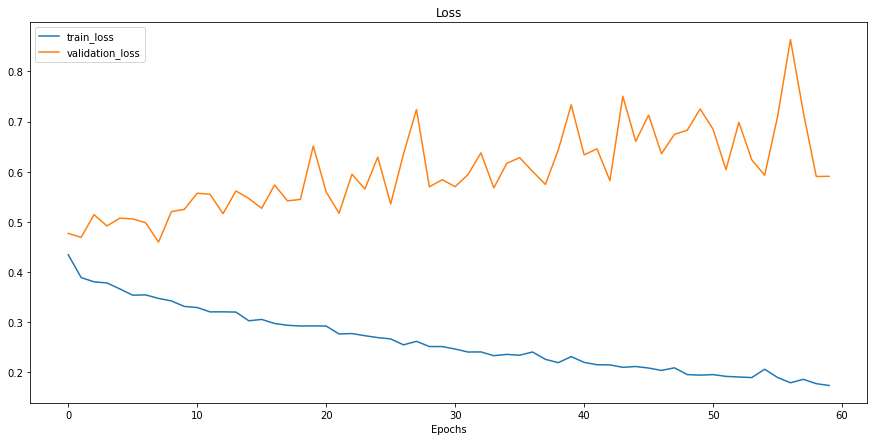

In [31]:
plt.figure(figsize=(15, 7))

    # Plot loss
plt.plot(range(len(t_loss)), t_loss, label='train_loss')
plt.plot(range(len(v_loss)), v_loss, label='validation_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

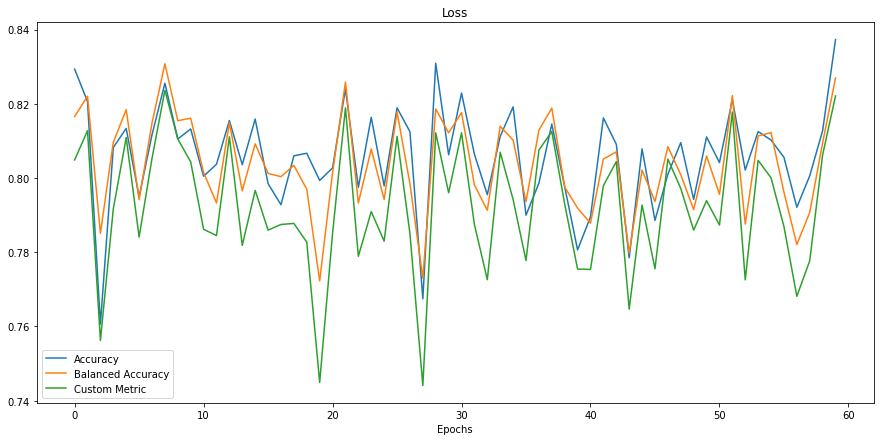

In [32]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(accur)), accur, label='Accuracy')
plt.plot(range(len(bal_accur)), bal_accur, label='Balanced Accuracy')
plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

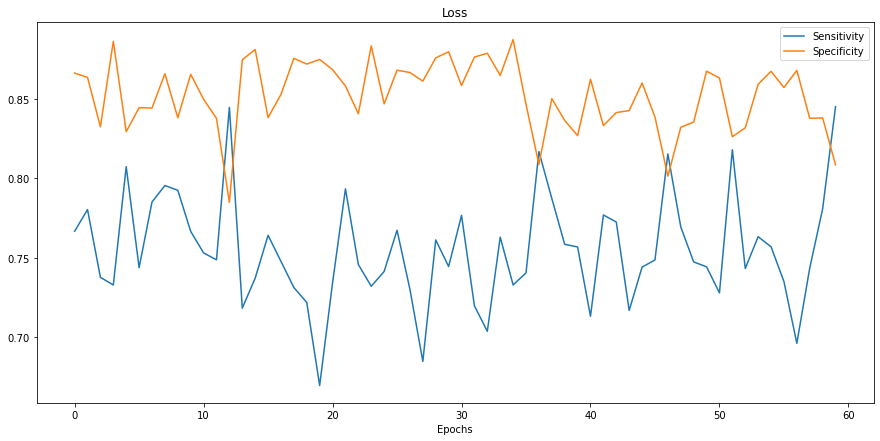

In [33]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(s1)), s1, label='Sensitivity')
plt.plot(range(len(s2)), s2, label='Specificity')
#plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

In [55]:
ckpt = torch.load("models/18_vip_cup_student_two_finetune_random_weight_epoch_52.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)
model = model.to(device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0214,  0.0384,  0.0431,  ...,  0.0266, -0.0211,  0.0353],
                        [ 0.0360,  0.0641, -0.0662,  ..., -0.1255,  0.0102,  0.0200],
                        [-0.0107, -0.0634, -0.1561,  ..., -0.1100, -0.2005, -0.0624],
                        ...,
                        [ 0.0138, -0.0212,  0.0187,  ...,  0.3211,  0.1473,  0.0885],
                        [ 0.1085,  0.0988,  0.1278,  ...,  0.1846,  0.1457, -0.0195],
                        [-0.0948, -0.0408, -0.1879,  ..., -0.2184, -0.1857,  0.0090]]],
              
              
                      [[[-0.1333, -0.0336,  0.1621,  ..., -0.1108,  0.1185, -0.1280],
                        [ 0.0536,  0.0377,  0.0231,  ...,  0.1059,  0.0680,  0.0200],
                        [ 0.0441, -0.0394, -0.1927,  ..., -0.1584,  0.0453,  0.0104],
                        ...,
                        [-0.1073, -0.0584, -0.0376,  ...,  0.1137, -0.1711, -0.0538],
                    

In [56]:
test_csv_path = 'TEST/test_set_submission_template.csv'
test_image_path = 'TEST/'

In [57]:
class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image, idx

In [58]:
test_dataset = RECOVERY(test_csv_path, test_image_path, val_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True,drop_last=False)

In [59]:
submission = pd.read_csv(test_csv_path)

In [60]:
model.eval()
with torch.no_grad():
    for idx, (image, index) in (enumerate(test_dataloader)):
        images = image.float().to(device)
        output = model(images)
        output = torch.round(torch.sigmoid(output))
        output = output.squeeze().cpu().numpy()
        index = int(index.numpy()[0])
        submission.iloc[index, 1:] = output

In [61]:
submission.to_csv('sub_eightin.csv', index=None)